In [678]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn 

In [679]:
#Read main data to DataFrame
cleaned_df = pd.read_csv('processed_data/cleaned_df.csv', index_col=0)  

In [680]:
df_original = pd.read_stata('Cash_and_Childhood_Development_Replication/macoursetal_main.dta')  

df_out=df_original[["a5sscore_i_06","a6smemory_p1_06","a6smemory_p2_06","a7a_delay_06","a7b_delay_06",
        "a7c_delay_06","a7d_delay_06","a9sgrossmotor_06","height_06","weight_06","z_tvip_06","z_social_06",
        "z_language_06","z_finmotor_06","z_memory_06","z_grmotor_06","z_legmotor_06","z_behavior_06","z_height_06",
        "z_weight_06","z_all_06"]]

In [681]:
cleaned_df.drop(cleaned_df[df_out.iloc[cleaned_df.index].z_all_06.isna()].index, axis=0, inplace=True)

In [682]:
cleaned_df["z_all_06"]=df_out.iloc[cleaned_df.index].z_all_06

In [683]:
cp_cols=["hogarid_old"]

In [684]:
cleaned_df.drop(cp_cols, axis=1, inplace=True)

In [685]:
def outlier_removal(df, cols):
    outlier_threshold = []
    for col in cols:
            q3 = np.nanpercentile(df[col], 75)
            q1 = np.nanpercentile(df[col], 25)
            iqr = q3 - q1
            out_low = q1 - 3*iqr
            out_high = q3 + 3*iqr
            outlier_threshold.append([out_low, out_high])
    outliers_indexs=[]
    for col,k in zip(cols,range(len(cols))):
        #outliers_indexs_in_col=[]
        for i in df[col].index:
            if df[col][i]<outlier_threshold[k][0] or df[col][i]>outlier_threshold[k][1]:
                outliers_indexs.append(i)
        #outliers_indexs.append(outliers_indexs_in_col)
    return df.drop(list(set(outliers_indexs)), axis=0)

cleaned_df=outlier_removal(cleaned_df, ["z_all_06"])

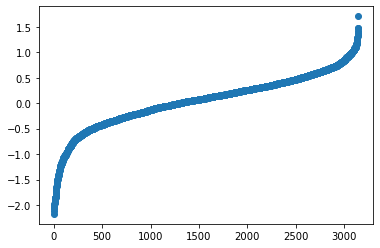

In [686]:
plt.scatter([i for i in range(len(cleaned_df["z_all_06"].sort_values().values))], cleaned_df["z_all_06"].sort_values().values)

(array([ 22.,  29.,  72., 166., 517., 921., 907., 409.,  96.,   6.]),
 array([-2.1753304 , -1.7871083 , -1.3988862 , -1.0106641 , -0.62244195,
        -0.23421985,  0.15400226,  0.54222435,  0.9304465 ,  1.3186686 ,
         1.7068907 ], dtype=float32),
 <BarContainer object of 10 artists>)

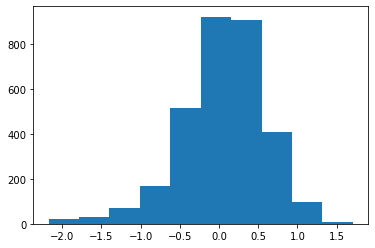

In [687]:
plt.hist(cleaned_df["z_all_06"])

In [688]:
cleaned_df["zall06_cat"] = pd.cut(cleaned_df["z_all_06"],
                               bins=[-np.inf, -0.75, -0.25, 0.25, 0.75, np.inf],
                               labels=[1, 2, 3, 4, 5])

In [689]:
cleaned_df["zall06_cat"].value_counts().sort_values()

1     204
5     212
2     574
4     962
3    1193
Name: zall06_cat, dtype: int64

In [690]:
treatment = 'tr'
outcome = 'z_all_06'
covariates = list(cleaned_df.columns)
covariates.remove(treatment)
covariates.remove(outcome)
covariates.remove("zall06_cat")

In [691]:
cleaned_df.z_all_06.values

array([ 0.45015588,  0.01125175, -0.5053326 , ...,  0.43954134,
        0.03532236, -0.03708899], dtype=float32)

In [692]:
from sklearn.model_selection import train_test_split
# split data into train and test sets 
train, test = train_test_split(cleaned_df, stratify=cleaned_df.zall06_cat, test_size=0.2, random_state=0)

# set variables for causal forest Y=outcome, T=treatment, X=covariates, W=effect_modifiers 
y_train = train[outcome]
X_train = train[covariates+["tr"]]
X_train_all=train[covariates+["tr"]+[outcome]]

X_test = test[covariates+["tr"]]
y_test =  test[outcome]
X_test_all=test[covariates+["tr"]+[outcome]]

In [693]:
def display_scores(scores,model_name = None):
    if(model_name):
        print("----",model_name,"----")
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [694]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(clf, X_train, y_train, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=clf,
        X=X_train,
        y=y_train,
        cv=3,
        scoring="neg_root_mean_squared_error",
        train_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    )

    train_mean = -train_scores.mean(axis=1)
    test_mean = -test_scores.mean(axis=1)

    plt.subplots(figsize=(5,4))
    plt.plot(train_sizes, train_mean, label="train")
    plt.plot(train_sizes, test_mean, label="validation")
    #plt.ylim(0,0.55)

    plt.title("Learning Curve"+title)
    plt.xlabel("Training Set Size")
    plt.ylabel("RMSE")
    plt.legend(loc="best")

    plt.show()

In [695]:
import lightgbm as lgb

In [696]:
counterfactual_df=cleaned_df.drop(["z_all_06", "zall06_cat"],axis=1)
a=counterfactual_df["tr"]+1
counterfactual_df["tr"]=a%2

In [697]:
best_lightgbm =lgb.LGBMRegressor(application='regression_l2', boosting_type='gbdt', 
                                  colsample_bytree=0.3004571253236143, extra_trees=True, 
                                  learning_rate= 0.07116177177396639, max_depth= 164,
                                  min_child_weight= 0.00850418085429701, min_split_gain= 0.08258787964701664,
                                  n_estimators=353, num_leaves= 101, reg_alpha= 0.006378130018392472,
                                  reg_lambda=0.006971035283303719, subsample= 0.9530989839136036,
                                  subsample_for_bin= 819, subsample_freq= 6)

In [698]:
best_lightgbm.fit(X_train, y_train)
counterfactual=best_lightgbm.predict(counterfactual_df)

In [699]:
feature_importances=pd.Series(best_lightgbm.feature_importances_, index=X_train.columns).sort_values()

<AxesSubplot:>

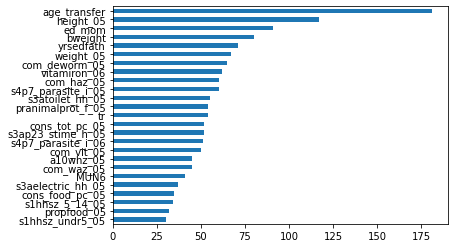

In [700]:
feature_importances[-25:].plot(kind='barh')

In [701]:
observed=cleaned_df["z_all_06"]
counterfactuals=pd.Series(counterfactual, index=observed.index)

In [702]:
ite_temp=pd.Series([observed[i]-counterfactuals[i] for i in observed.index if cleaned_df.tr[i]==1]
                   , index=cleaned_df[cleaned_df.tr==1].index)
ite_temp1=pd.Series([counterfactuals[i]-observed[i] for i in observed.index if cleaned_df.tr[i]==0]
                    , index=cleaned_df[cleaned_df.tr==0].index)
ite=pd.concat([ite_temp,ite_temp1])
ite.sort_index(inplace=True)

In [703]:
ite_df=counterfactual_df.copy()
ite_df.drop(["tr"], axis=1, inplace=True)
ite_df["ite"]=ite

In [704]:
ite_in=ite_df.drop("ite", axis=1).copy()

In [705]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

#definim una escala de color d'acord amb la nostra ite
cmap = cm.RdYlGn
norm = Normalize(vmin=-0.5, vmax=0.5)
#cuncio que convertir RGB a hex
def rgb_to_hex(rgb):
    for i in range(3):
        return ('#%02x%02x%02x' % (int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255)))

def replace_color (dot_data, values):
    inici=0
    for i in range(len(values)):
        index=dot_data[inici:].find("fillcolor=")+11+inici
        color=dot_data[index:index+7]
        inici=index+7
        old=color
        new=rgb_to_hex(cmap(norm(values[i]))[:-1])
        dot_data=dot_data.replace(old, new, 1)
    return dot_data

In [706]:
## funcions que ens permeten calcular els CATEs de les fulles del decision tree entrenat sobre l'ITE. 

#cate: donat un subgrup del nostre dataset, en calcula el cate

def cate(df):
    t=df[df.tr==1].z_all_06 
    c=df[df.tr==0].z_all_06
    
    if((len(t)==0 or len(c)==0)):
        cate= -999
    else:
        cate= np.mean(t)-np.mean(c)
    if len(df)!=0:
        size=(len(df)-len(t))/len(df)*100
    else:
        size=0
    return [cate, size]

#donada una estructura d'arbre, i un dataset (control i tractament) retorna l'arbre amb el comput del cate a cada fulla

def cate_tree(dec_tree, df):
    tree_str=dec_tree.tree_
    
    #vector amb threshold dels splits (-2 si la fulla no te fills)
    threshold=tree_str.threshold 

    #vector amb variable usada en cada split
    numeric_features=tree_str.feature
    num_leafs=len(tree_str.feature)
    features=[]
    for i in numeric_features:
        if i>=0:
            features.append(df.columns[i])
        else:
            features.append(-2)
    
    n_split=np.sum(threshold!=-2) #nombre de splits
    df_vec=[] #vector amb els df dels subgrups de df que cauen a cada fulla
    df_vec=[df.copy()]*num_leafs #posem el node inicial, els altres els reescriurem
    index_vec=[[0]] 

    for i in range(n_split):#emplenem df_vec
        for index in index_vec[i]: #per a cada nivell de l'arbre, creem un vector amb els fills de les fulles del nivell
            if  threshold[index]!=-2:
                left_children=tree_str.children_left[index]
                right_children=tree_str.children_right[index]
                index_vec.append( [left_children, right_children])

                father_df=df_vec[index].copy()
                df_vec[left_children]=father_df[father_df[features[index]]<=threshold[index]].copy()
                df_vec[right_children]=father_df[father_df[features[index]]>threshold[index]].copy()
    len_vec=[len(df) for df in df_vec]
    cate_vec=[cate(df)[0] for df in df_vec] #calculem els cates corresponents als subgrups guardats en df_vec
    size_vec=[cate(df)[1] for df in df_vec]

    return cate_vec, size_vec
    


In [707]:
#funció que canvia els valors de les fulles del decision tree (mitjanes de l'ite) per els corresponents CATEs
# obtinguts amb la funció previa

def replace_values (dot_data, new_values):
    inici=0
    for i in range(len(new_values)):
        index=dot_data[inici:].find("nvalue = ")+9+inici
        word=dot_data[index:index+6]
        long=len([int(s) for s in list(word) if s.isdigit()])
        signe=len([1 for s in list(word) if s=="-"])
        number=dot_data[index:index+long+1+signe]
        inici=index+long+1+signe
        old="nvalue = "+number
        new="nvalue = "+str(new_values[i])
        dot_data=dot_data.replace(old, new, 1)
    return dot_data

In [708]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
import graphviz
import os 

#entrenem un decision tree sobre el el nostre dataset, amb output l'ITE, per tal d'estratificar-lo
dec_tree= DecisionTreeRegressor(max_depth=3, min_samples_leaf=30).fit(ite_in, ite_df.ite)

dot_data = tree.export_graphviz(dec_tree, out_file=None, 
                                feature_names=ite_in.columns, filled=True,
                               rounded=True)
#Canviem el color 
cmap_values=[row[0,0] for row in dec_tree.tree_.value]
dot_data=replace_color(dot_data, cmap_values)

#Draw graph
ite_dt = graphviz.Source(dot_data, format="png") 

In [709]:
#calculem els valors observacionals del CATE per a cada fulla del nostre arbre
ite_in1=ite_in.copy()
ite_in1["z_all_06"]=cleaned_df.z_all_06
ite_in1["tr"]=cleaned_df.tr

cate_values, size=cate_tree(dec_tree, ite_in1)

dot_data1=replace_values(dot_data, cate_values)
dot_data1=replace_color(dot_data1, cate_values)
cate_dt = graphviz.Source(dot_data1, format="png") 

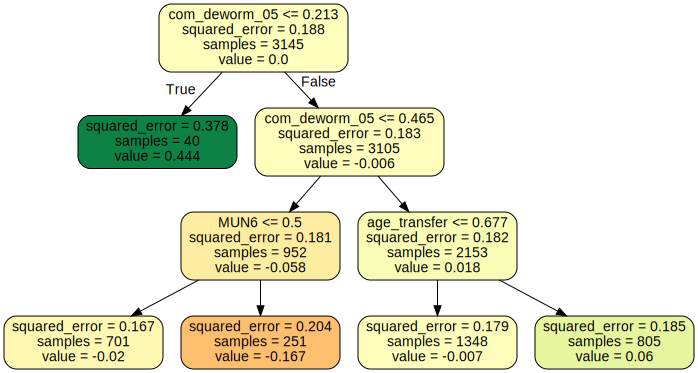

In [710]:
ite_dt

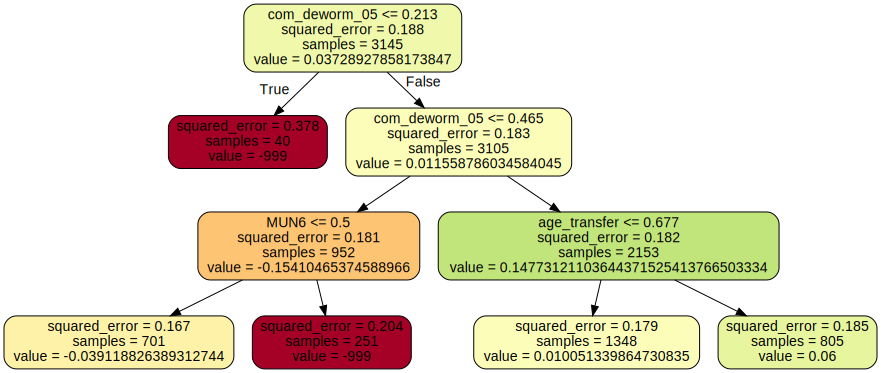

In [711]:
cate_dt

In [712]:
ite_leafs=[row[0,0] for row in dec_tree.tree_.value]
error=[np.abs(ite_leafs[i]-cate_values[i]) for i in range(len(cate_values))]
error_df=pd.DataFrame([error,cate_values]).transpose().copy()
error_df.columns=["Error", "Cate"]
error_df["Error rel"]=(error_df.Error/error_df.Cate)*100
error_df["Control %"]=size

In [713]:
error_df

,Error,Cate,Error rel,Control %
0,0.037167,0.037289,99.671699,25.055644
1,999.443554,-999.000000,-100.044400,100.000000
2,0.017149,0.011559,148.361995,24.090177
3,0.095677,-0.154105,-62.085499,14.495798
4,0.019481,-0.039119,-49.799794,19.686163
5,998.833237,-999.000000,-99.983307,0.000000
6,0.043752,0.061525,71.111949,28.332559
7,0.017371,0.010051,172.818714,28.338279
8,0.087939,0.147731,59.526386,28.322981


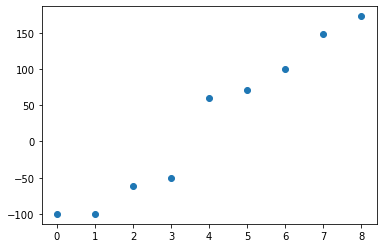

In [714]:
plt.scatter([i for i in range(len(error_df["Error rel"]))], error_df["Error rel"].sort_values() )

### ANALISI INDIVIDUAL (NO COMUNITARI)

In [715]:
#fem una subselecció de variables, descartant aquelles de tipus comunitari (ens quedem amb les individuals i familiars)
individual_features=['s1age_head_05', 's1hhsize_05', 's1hhsz_undr5_05', 's1hhsz_5_14_05',
       's1hhsz_15_24_05', 's1hhsz_25_64_05', 's1hhsz_65plus_05',
       's1male_head_05', 's2mother_inhs_05', 's3ap5_rooms_h_05',
       's3ap23_stime_h_05', 's3ap24_htime_h_05', 's3ap25_hqtime_h_05',
       's3atoilet_hh_05', 's3awater_access_hh_05', 's3aelectric_hh_05',
       's4p6_vitamina_i_05', 's4p7_parasite_i_05', 's11ownland_hh_05',
       'cons_food_pc_05', 'cons_tot_pc_05', 'height_05', 'a10whz_05',
       'weight_05', 'yrsedfath', 'age_transfer', 'bweight',
       's4p7_parasite_i_06', 'tr', 'male', 'ed_mom', 'vitamiron_06', 'propfood_05', 'prstap_f_05',
       'pranimalprot_f_05', 'prfruitveg_f_05']
individual_df=cleaned_df[['s1age_head_05', 's1hhsize_05', 's1hhsz_undr5_05', 's1hhsz_5_14_05',
       's1hhsz_15_24_05', 's1hhsz_25_64_05', 's1hhsz_65plus_05',
       's1male_head_05', 's2mother_inhs_05', 's3ap5_rooms_h_05',
       's3ap23_stime_h_05', 's3ap24_htime_h_05', 's3ap25_hqtime_h_05',
       's3atoilet_hh_05', 's3awater_access_hh_05', 's3aelectric_hh_05',
       's4p6_vitamina_i_05', 's4p7_parasite_i_05', 's11ownland_hh_05',
       'cons_food_pc_05', 'cons_tot_pc_05', 'height_05', 'a10whz_05',
       'weight_05', 'yrsedfath', 'age_transfer', 'bweight',
       's4p7_parasite_i_06', 'male', 'ed_mom', 'vitamiron_06', 'propfood_05', 'prstap_f_05',
       'pranimalprot_f_05', 'prfruitveg_f_05']].copy()

In [716]:
individual_df1=individual_df.copy()
dec_tree_ind= DecisionTreeRegressor(max_depth=3, min_samples_leaf=50).fit(individual_df1, ite_df.ite)

dot_data_ind = tree.export_graphviz(dec_tree_ind, out_file=None, 
                                feature_names=individual_df.columns, filled=True,
                               rounded=True)
#Canviem el color 
cmap_values=[row[0,0] for row in dec_tree_ind.tree_.value]
dot_data_ind=replace_color(dot_data_ind, cmap_values)

#Draw graph
ite_ind_dt = graphviz.Source(dot_data_ind, format="png") 

In [717]:
individual_df["z_all_06"]=cleaned_df.z_all_06
individual_df["tr"]=cleaned_df.tr

cate_values,size=cate_tree(dec_tree_ind, individual_df)

dot_data_ind1=replace_values (dot_data_ind, cate_values)
dot_data_ind1=replace_color(dot_data_ind1, cate_values)
cate_dt_ind= graphviz.Source(dot_data_ind1, format="png") 

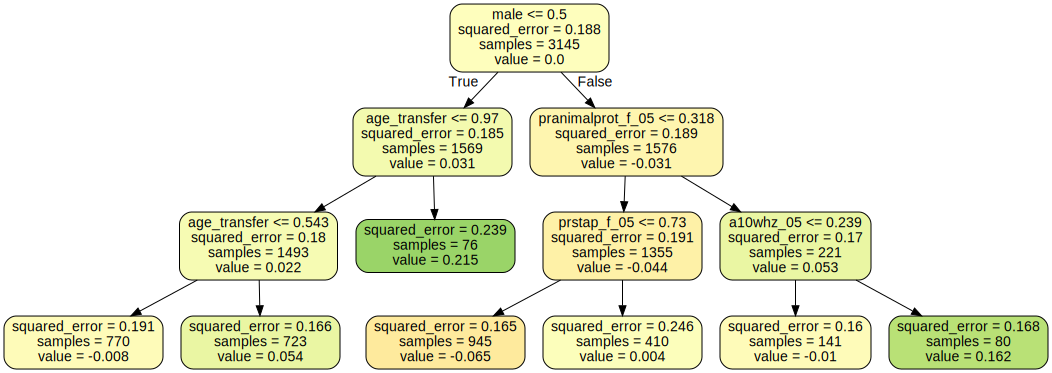

In [718]:
ite_ind_dt

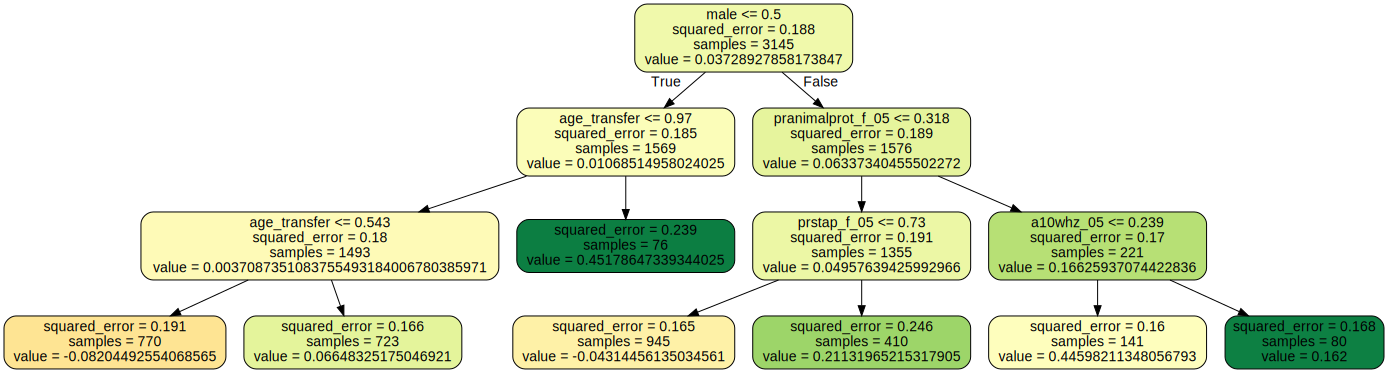

In [719]:
cate_dt_ind

In [720]:
#calculem l'error relatiu

ite_leafs=[row[0,0] for row in dec_tree_ind.tree_.value]
error=[np.abs(ite_leafs[i]-cate_values[i]) for i in range(len(cate_values))]
error_df=pd.DataFrame([error,cate_values]).transpose().copy()
error_df.columns=["Error", "Cate"]
error_df["Error rel"]=(error_df.Error/error_df.Cate)*100
error_df["Control %"]=size

In [721]:
error_df

,Error,Cate,Error rel,Control %
0,0.037167,0.037289,99.671699,25.055644
1,0.020359,0.010685,190.538413,24.729127
2,0.033511,-0.011840,-283.033717,24.782317
3,0.073571,-0.082045,-89.670996,25.194805
4,0.012707,0.066483,19.112354,24.343015
5,0.236609,0.451786,52.371862,23.684211
6,0.094036,0.063373,148.383511,25.380711
7,0.093804,0.049576,189.211650,24.944649
8,0.022014,-0.043145,-51.024732,23.280423
9,0.207304,0.211320,98.099764,28.780488


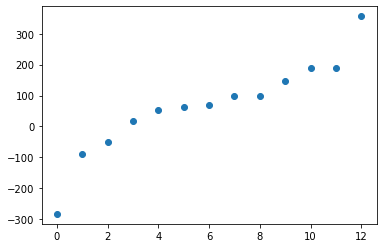

In [722]:
plt.scatter([i for i in range(len(error_df["Error rel"]))], error_df["Error rel"].sort_values() )